In [13]:
import os
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

DIR_HOME = pathlib.Path("..").absolute()
DIR_EVAL = DIR_HOME / "data" / "evaluations"

<Axes: xlabel='NDCG@10', ylabel='Dataset Name'>

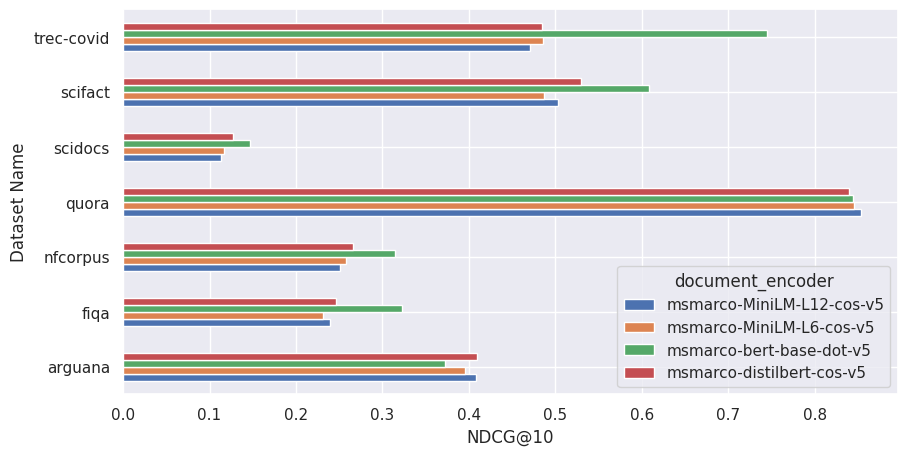

In [3]:
df_no_distill = pd.read_csv(DIR_EVAL / "eval_results_symmetric.csv")
df_no_distill.pivot(index="dataset_name",
                    columns="document_encoder",
                    values="NDCG@10") \
             .plot.barh(figsize=(10, 5),
                        xlabel="NDCG@10",
                        ylabel="Dataset Name")

<Axes: xlabel='Dataset Name', ylabel='NDCG@10'>

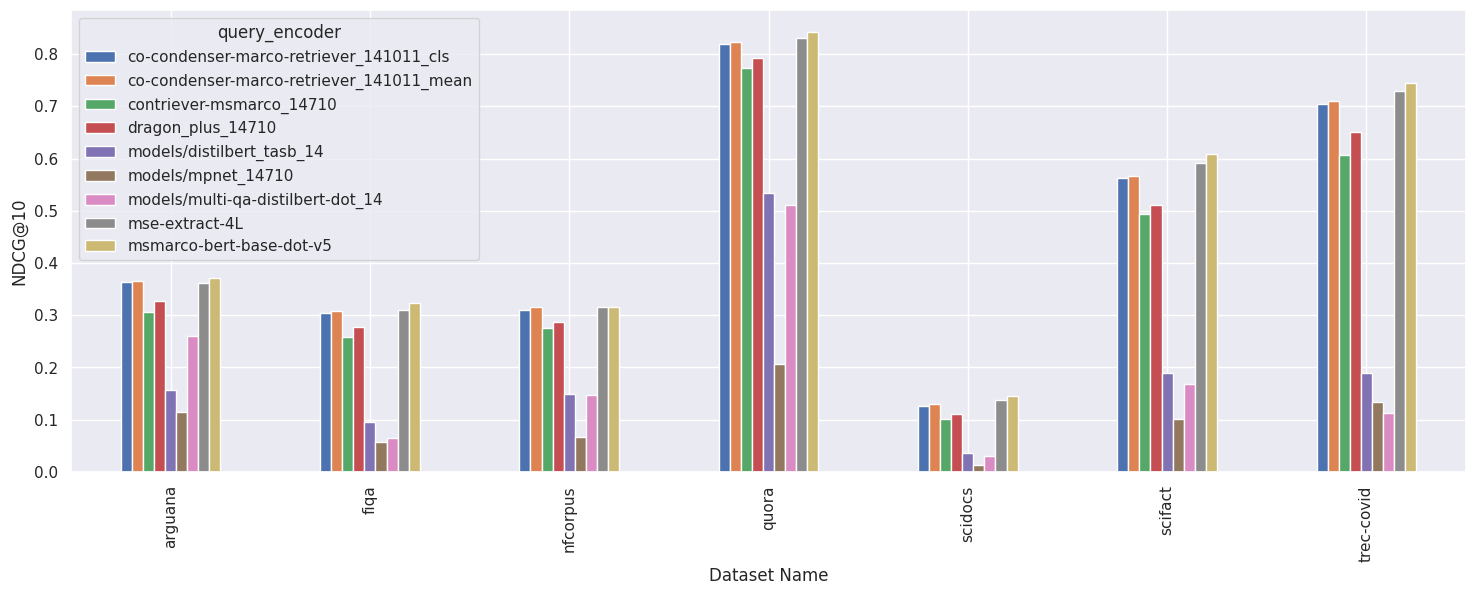

In [5]:
df_distill = pd.read_csv(DIR_EVAL / "eval_results_distill_4L.csv")
df_distill.pivot(index="dataset_name",
                 columns="query_encoder",
                 values="NDCG@10") \
          .plot.bar(figsize=(18, 6),
                    ylabel="NDCG@10",
                    xlabel="Dataset Name")

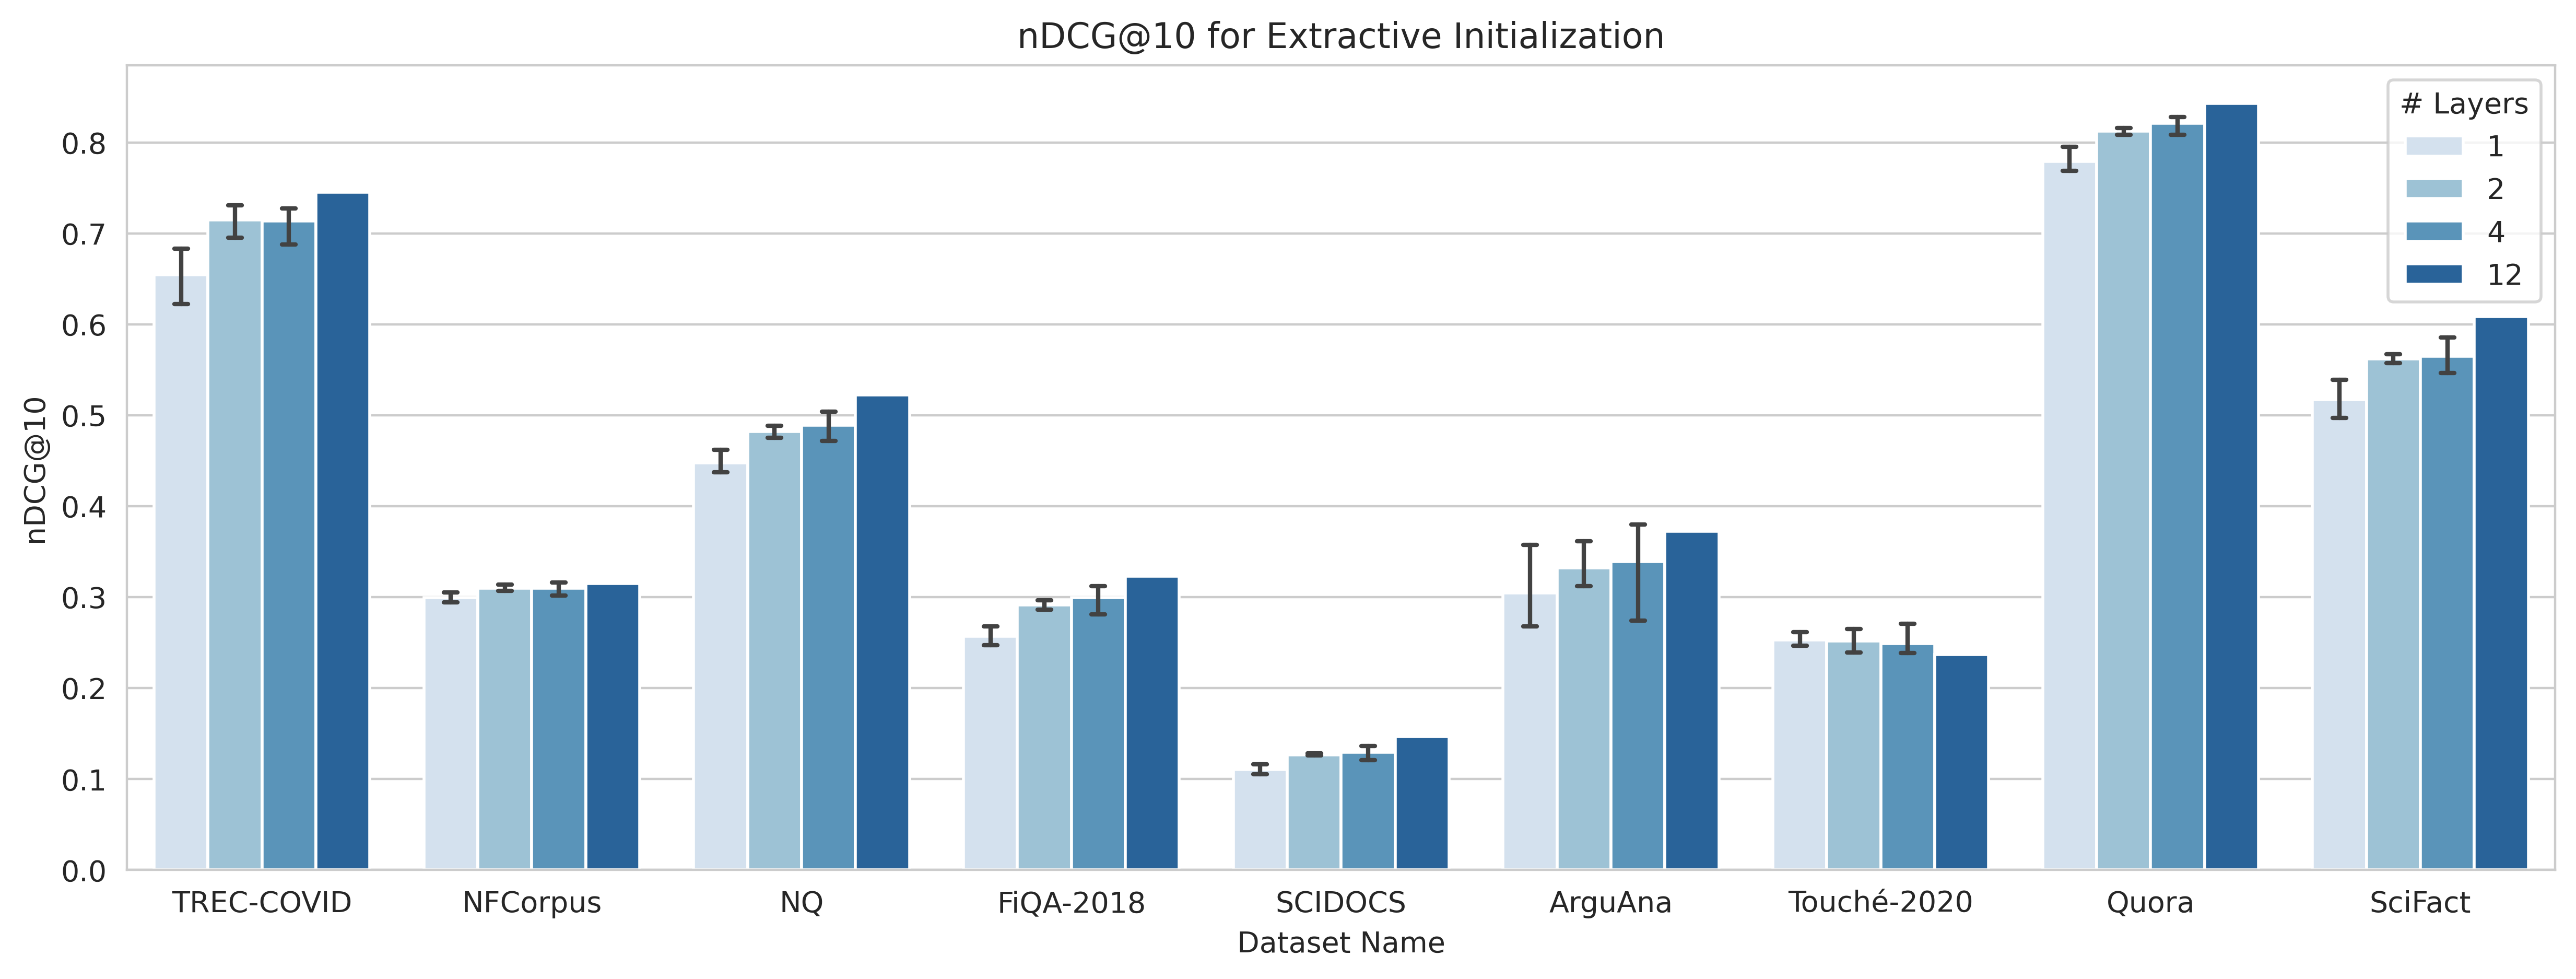

In [25]:
def get_num_layers(x) -> str:

    import re

    pattern = re.compile(r"basemodel_(\d+)layer")
    match = pattern.search(x)
    if match:
        return int(match.group(1))
    return 12


def get_ds_name(x) -> str:
    table = {
        "msmarco":          "MS MARCO",
        "webis-touche2020": "Touché-2020",
        "fiqa":             "FiQA-2018",
        "trec-covid":       "TREC-COVID",
        "nfcorpus":         "NFCorpus",
        "nq":               "NQ",
        "quora":            "Quora",
        "scifact":          "SciFact",
        "scidocs":          "SCIDOCS",
        "arguana":          "ArguAna",
        "dbpedia-entity":   "DBpedia-Ent",
    }
    return table[x]


df_extract = pd.read_csv(DIR_EVAL / "eval_results_extract.csv")
df_extract["n_layers"] = df_extract["query_encoder"].map(get_num_layers)
df_extract["dataset_name"] = df_extract["dataset_name"].map(get_ds_name)

fig, ax = plt.subplots(figsize=(15, 5), dpi=400)
barplot = sns.barplot(data=df_extract,
                      x="dataset_name",
                      y="NDCG@10",
                      errorbar=lambda x: (x.min(), x.max()),
                      hue="n_layers",
                      palette=sns.color_palette("Blues", n_colors=df_extract["n_layers"].nunique()),
                      capsize=.05,
                      errwidth=1.5,
                      ax=ax)

ax.set_title("nDCG@10 for Extractive Initialization")
ax.set_xlabel("Dataset Name")
ax.set_ylabel("nDCG@10")
ax.legend(title="# Layers")